# pipline V2

***Macros***

In [395]:
PATH = "Datasets/housing.csv"
STRAT_COL = "median_income"

In [396]:
# imports 
import os
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder

try: 
    from sklearn.impute import SimpleImputer
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer


# Data Preperation methods.

In [397]:
#imports the dataset from filepath retrns a df object
def import_file(filepath):
    file = pd.read_csv(filepath)
    return file

In [398]:
# feature scaling of median_income reduces it to 5 bin catagories returns a new df object
def income_cat(df): 
    df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])
    df = df.drop(["median_income"], axis="columns")
    return df

In [399]:
# Splits the data into the training and test sets. They will have an equal income_cat distribution
def strat_split_data(file):
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(file, file["income_cat"]):
        strat_train_set = file.loc[train_index]
        strat_test_set = file.loc[test_index]
    return strat_train_set, strat_test_set

In [400]:
def plot_data(df):
    plot = df.plot(kind="scatter", figsize=(12,7), x='latitude',
                   y='longitude', c="median_house_value", cmap=plt.get_cmap("jet"),
                   s=df['population']/100, sharex=False)
    plot.legend()
    return plot

In [401]:
def plot_features(df):
    return df.hist(bins=50, figsize=(20,15))

In [402]:
def split_data_labels(df): 
    data = df.drop(["median_house_value"], axis='columns')
    labels = df["median_house_value"]
    return data, labels

## lets collect the methods to just a couple of functions

In [403]:
def visualise_data():
    data = import_file(PATH)
    plot_features(data)
    plot_data(data)
    

# create custom pipeline methods


* Split DataFrame into catagorical and numeric parts

In [404]:
df = import_file(PATH)
list(df.keys())

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

In [405]:
def split_cat_num(df): 
    cat_df = df["ocean_proximity"]
    num_df = df.drop(["ocean_proximity"], axis="columns")
    return cat_df, num_df

In [406]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_ix, bedrooms_ix, population_ix, household_ix = [
        list(X.columns).index(col)
        for col in ("total_rooms", "total_bedrooms", "population", "households")]

        rooms_per_household = X.iloc[:, rooms_ix] / X.iloc[:, household_ix]
        population_per_household = X.iloc[:,household_ix] / X.iloc[:, population_ix]
        if self.add_bedrooms_per_room: 
            bedrooms_per_room = X.iloc[:, rooms_ix] / X.iloc[:, bedrooms_ix]
            return np.c_[X, bedrooms_per_room, population_per_household, rooms_per_household]
        else: 
            return np.c_[X, population_per_household, rooms_per_household]

In [407]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, cat_attributes):
        self.cat_attributes = cat_attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        selected_cols = []
        col_list = list(X.columns)
        if self.cat_attributes == False:
            for key in col_list:
                 if X[key].dtypes == 'float64':
                    selected_cols.append(key)
            return X[selected_cols]
        else: 
            for key in col_list: 
                if X[key].dtypes != 'float64':
                    selected_cols.append(key)
                else:
                    pass
        return X[selected_cols]

In [408]:
class cat_encoder(BaseEstimator, TransformerMixin): 
    def __init_(self, encode=True): 
        self.encode = True
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        Y = pd.DataFrame(X)
        Y['ocean_proximity_NEAR BAY'] = X['ocean_proximity'].replace(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'], 
                                                                                     [1.0, 0.0, 0.0, 0.0, 0.0])
        Y['ocean_proximity_<1H OCEAN'] = X['ocean_proximity'].replace(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'], 
                                                                             [0.0, 1.0, 0.0, 0.0, 0.0])
        Y['ocean_proximity_INLAND'] = X['ocean_proximity'].replace(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'], 
                                                                             [0.0, 0.0, 1.0, 0.0, 0.0])
        Y['ocean_proximity_NEAR OCEAN'] = X['ocean_proximity'].replace(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'], 
                                                                             [0.0, 0.0, 0.0, 1.0, 0.0])
        Y['ocean_proximity_ISLAND'] = X['ocean_proximity'].replace(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'], 
                                                                             [0.0, 0.0, 0.0, 0.0, 1.0])
        Y = Y.drop(['ocean_proximity'], axis='columns')
        return Y



***Now to collect the processes together in the pipeline***

In [409]:
num_pipeline = Pipeline([
    ('df Selector', DataFrameSelector(False)),
    ('attribs_adder', CombinedAttributesAdder()),
    ('imputer', SimpleImputer(strategy="median")), 
    ('std_scaler', StandardScaler()),
    ])


In [410]:
cat_pipeline = Pipeline([
    ('df Selector', DataFrameSelector(True)), 
    ('cat_encoder', cat_encoder())
])

In [411]:
full_pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [412]:
def data_prep():
    data = import_file(PATH)
    data1 = income_cat(data)
    train_set, test_set = strat_split_data(data1)
    
    train_set_data, train_set_labels = split_data_labels(train_set)
    test_set_data, test_set_labels = split_data_labels(test_set)
    test_set_data = full_pipeline.fit_transform(test_set_data)
    train_set_data = full_pipeline.fit_transform(train_set_data)
    
    dict = {'train_set_data':train_set_data, 
            'train_set_labels':train_set_labels, 
            'test_set_data':test_set_data, 
            'test_set_labels':test_set_labels}
    return dict

# Now lets Train some models

In [413]:
from sklearn.linear_model import LinearRegression

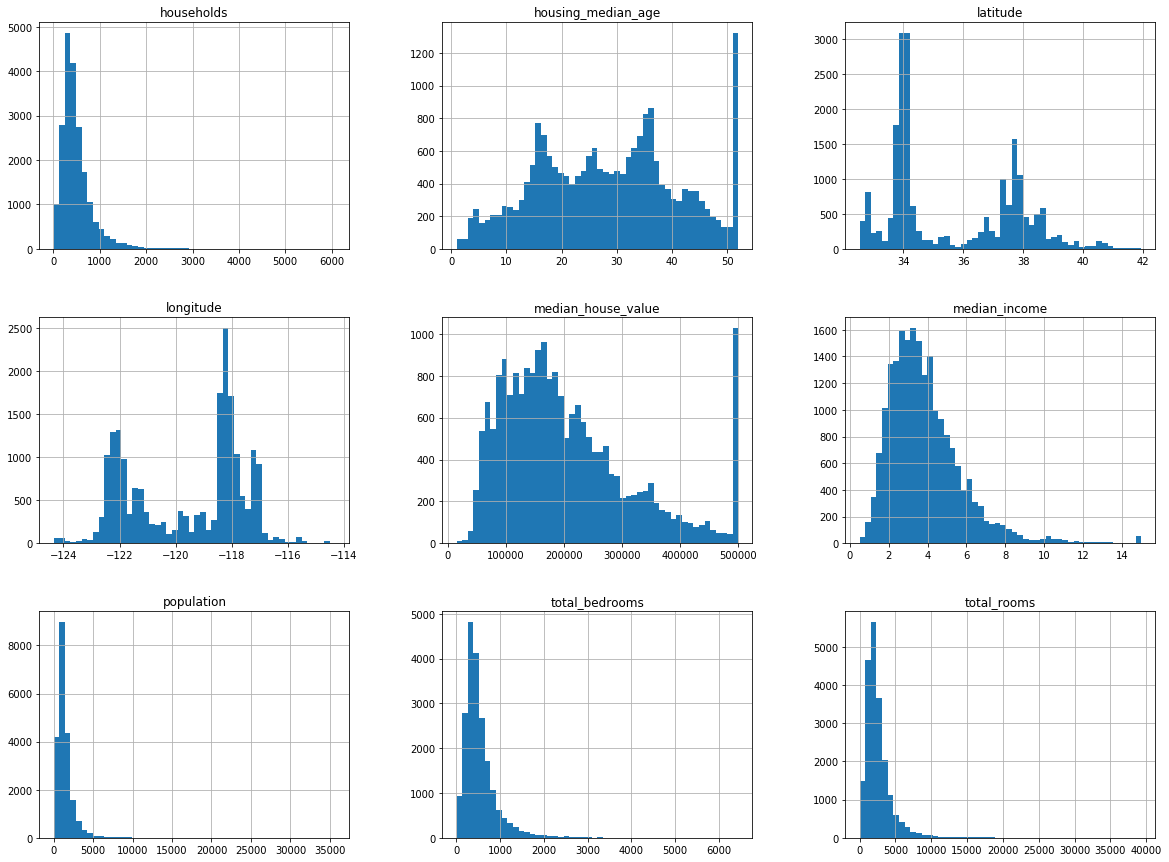

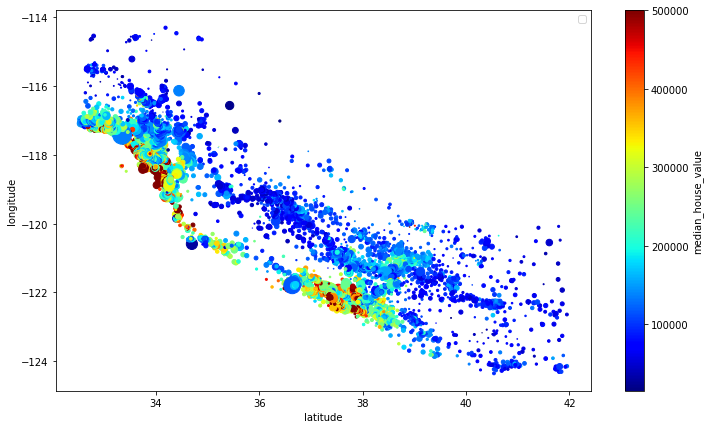

In [414]:
visualise_data()

In [415]:
data_dict = data_prep()
data_dict.keys()

['test_set_labels', 'train_set_data', 'test_set_data', 'train_set_labels']

In [416]:
data_dict['train_set_data']

array([[-1.1560428086829155, 0.7719496164846016, 0.7433308916510305, ...,
        0.0, 0.0, 0.0],
       [-1.1760248286103931, 0.6596947951050618, -1.165317203353399, ...,
        0.0, 0.0, 0.0],
       [1.186849027813462, -1.3421828528300457, 0.1866418639414053, ...,
        0.0, 1.0, 0.0],
       ...,
       [1.5864894263629494, -0.7247813352425817, -1.5629522231459883,
        ..., 1.0, 0.0, 0.0],
       [0.7822131242821033, -0.8510680092945644, 0.1866418639414053, ...,
        0.0, 0.0, 0.0],
       [-1.435791087667559, 0.9964592592436813, 1.8567089470702811, ...,
        0.0, 0.0, 0.0]], dtype=object)

In [417]:
lin_reg = LinearRegression()
lin_reg.fit(data_dict['train_set_data'], data_dict['train_set_labels'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [418]:
some_data = pd.DataFrame(data_dict['train_set_data']).iloc[0:5,]

lin_reg.predict(some_data_prepared)

array([210637.65178466, 349458.66055187, 206128.85162577,  44429.30297709,
       196970.72931505])

### Evaluating the LinearRegression Model

In [419]:
from sklearn.metrics import mean_squared_error
data = data_dict['train_set_data']
pd.DataFrame(data).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.15604,0.77195,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.445087,1.21306,-0.312055,2,0,1,0,0,0
1,-1.17602,0.659695,-1.16532,-0.908967,-1.03693,-0.998331,-1.02223,1.11138,0.0542933,0.217683,5,0,1,0,0,0
2,1.18685,-1.34218,0.186642,-0.31366,-0.153345,-0.433639,-0.0933178,-0.72123,1.38577,-0.465315,2,0,0,0,1,0
3,-0.0170677,0.313576,-0.29052,-0.362762,-0.396756,0.036041,-0.383436,-0.00786083,-1.31137,-0.0796612,2,0,0,1,0,0
4,0.492474,-0.659299,-0.926736,1.85619,2.41221,2.72415,2.57097,-0.568774,-0.386795,-0.357834,3,0,1,0,0,0


In [420]:
housing_predictions = lin_reg.predict(data_dict['train_set_data'])
lin_mse = mean_squared_error(data_dict['train_set_labels'], housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

70808.10438090506

**This is not great. means the value prediction is typically of by 70k! This model is underfitting lets see if a more powerful complex model is more effective?**

In [421]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(data_dict['train_set_data'], data_dict['train_set_labels'])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [422]:
predictions = dtr.predict(data_dict['train_set_data'])
tree_mse = mean_squared_error(data_dict['train_set_labels'], predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

***Apparently the model is perfect and predicting everything correctly. It is clearly overfitting***

A better way to evaluate the model is to use cross-validation. specifically k-fold cross-validation. The data will be split into K parts. the model trained on k-1 parts and then tested on the other. This is repeated k times for all the different folds. 

In [423]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(dtr, data_dict['train_set_data'], data_dict['train_set_labels'], scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([69868.06320903, 69297.56919382, 72104.77950974, 66722.66275365,
       67791.77929392, 73526.80603194, 70589.34855847, 71327.51926945,
       71999.19608575, 71700.44877809])

In [424]:
tree_rmse_scores.mean()

70492.81726838448

In [425]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor()
model = RFR.fit(data_dict['train_set_data'], data_dict['train_set_labels'])
scores = cross_val_score(RFR, data_dict['train_set_data'], data_dict['train_set_labels'], scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
forest_rmse_scores

array([54485.20004588, 51859.92692824, 52566.94900132, 52787.2693384 ,
       52461.22104122, 57013.9731934 , 50163.9663484 , 51847.22446148,
       54457.23176048, 53370.00418375])

The score for the RandomForestRegressor is much better than the tree

In [426]:
fores_rmse_scores.mean()

54577.38588875527

***to save the models you can use joblib***

In [427]:
from sklearn.externals import joblib
joblib.dump(lin_reg, "lin_reg.pkl")
joblib.dump(dtr, "Decision_tree.pkl")
joblib.dump(RFR, "Random_forest.pkl")

['Random_forest.pkl']

In [428]:
# should you want to reload one of the models
loaded_model = joblib.load("lin_reg.pkl")

## Fine Tuning the Models
One way to fine tune is to fiddle with the hyperparameters until you find a combination. You can use Scikit-Learns GridSearchCV to search 

In [429]:
from sklearn.model_selection import GridSearchCV 

param_grid = [
    {'n_estimators':[3, 10, 30, 40], 'max_features':[2, 4, 6, 8, 10]}, 
    {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features': [2, 3, 4]}, 
]

In [430]:
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(data_dict['train_set_data'], data_dict['train_set_labels'])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30, 40], 'max_features': [2, 4, 6, 8, 10]}, {'n_estimators': [3, 10], 'max_features': [2, 3, 4], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [431]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 40}

In [432]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [433]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
                                    

(65193.83579612262, {'max_features': 2, 'n_estimators': 3})
(56989.32298407456, {'max_features': 2, 'n_estimators': 10})
(54330.97227931984, {'max_features': 2, 'n_estimators': 30})
(53901.85002847721, {'max_features': 2, 'n_estimators': 40})
(61895.8764175774, {'max_features': 4, 'n_estimators': 3})
(54398.61171752082, {'max_features': 4, 'n_estimators': 10})
(51935.94972296372, {'max_features': 4, 'n_estimators': 30})
(51816.2045256057, {'max_features': 4, 'n_estimators': 40})
(60498.304195848235, {'max_features': 6, 'n_estimators': 3})
(53641.120853795095, {'max_features': 6, 'n_estimators': 10})
(51206.09726596087, {'max_features': 6, 'n_estimators': 30})
(51330.128189107236, {'max_features': 6, 'n_estimators': 40})
(58959.51830311136, {'max_features': 8, 'n_estimators': 3})
(52748.201665094326, {'max_features': 8, 'n_estimators': 10})
(51336.08400638249, {'max_features': 8, 'n_estimators': 30})
(50606.98002661197, {'max_features': 8, 'n_estimators': 40})
(59921.1925755081, {'max_f

## Ensemble methods

In [434]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.30069626e-02, 7.33413694e-02, 4.91219213e-02, 1.74282953e-02,
       1.63366959e-02, 1.71937586e-02, 1.55859828e-02, 7.40835613e-02,
       1.19855675e-01, 6.58158754e-02, 2.91417963e-01, 2.82207544e-03,
       7.45169645e-03, 1.62373663e-01, 4.08336706e-03, 8.11367485e-05])

In [435]:
columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
           'households', 'median_income', 'median_house_value', 'bedrooms_per_room', 'population_per_household', 'rooms_per_household'  'ocean_proximity_NEAR BAY', 'ocean_proximity_<1H OCEAN',
           'ocean_proximity_INLAND', 'ocean_proximity_NEAR OCEAN', 'ocean_proximity_ISLAND']

In [436]:
i = 0
while i<16: 
    print('feature: ', feature_importances[i], '  ', columns[i])
    i = i+1

('feature: ', 0.08300696263458562, '  ', 'longitude')
('feature: ', 0.07334136938078642, '  ', 'latitude')
('feature: ', 0.04912192130480221, '  ', 'housing_median_age')
('feature: ', 0.017428295276745914, '  ', 'total_rooms')
('feature: ', 0.01633669589910671, '  ', 'total_bedrooms')
('feature: ', 0.0171937586316172, '  ', 'population')
('feature: ', 0.015585982801013637, '  ', 'households')
('feature: ', 0.07408356133340109, '  ', 'median_income')
('feature: ', 0.11985567503844186, '  ', 'median_house_value')
('feature: ', 0.0658158754014761, '  ', 'bedrooms_per_room')
('feature: ', 0.2914179633161033, '  ', 'population_per_household')
('feature: ', 0.0028220754404567018, '  ', 'rooms_per_householdocean_proximity_NEAR BAY')
('feature: ', 0.0074516964534293365, '  ', 'ocean_proximity_<1H OCEAN')
('feature: ', 0.16237366327465072, '  ', 'ocean_proximity_INLAND')
('feature: ', 0.004083367064861184, '  ', 'ocean_proximity_NEAR OCEAN')
('feature: ', 8.113674852206566e-05, '  ', 'ocean_pro

## Evaluate System on the Test Set

In [437]:
final_model = grid_search.best_estimator_

data_dict.keys()

['test_set_labels', 'train_set_data', 'test_set_data', 'train_set_labels']

In [438]:

X_test = data_dict["test_set_data"]
y_test = data_dict["test_set_labels"]

final_predictions = final_model.predict(X_test)

In [440]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

52562.70328446219